# Testing the Utility Functions

In [2]:
import numpy as np

## Geting parameters for a certain observation time

### get_p_at_t()

In [3]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.trajectory.ode import SchwarzEccFlux
from few.trajectory.ode import PN5
from few.utils.utility import get_p_at_t,get_separatrix,get_mu_at_t
from few.utils.constants import YRSID_SI


In [4]:
traj_module = EMRIInspiral(func=KerrEccEqFlux)

In [5]:
M = 9700484.894655073
mu = 25.806654874357793
e0 = 0.3635415084736439
# a= 0.6834440767965327
a = 0.6834440767965327
xI0 = 1.

p0 = traj_module.func.min_p(e0,xI0, a)

T = 1  # duration of trajectory in years (as defined by few.utils.constants.YRSID_SI)

traj_pars = [M, mu, a, p0, e0, xI0]

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_module(*traj_pars, T=T)
e[-1]


np.float64(0.3635427578522447)

In [93]:
get_separatrix(a,e[-1],xI0)

3.935430307309695

In [94]:
# So the solution is to run a basic test of running a single trajectory at p_min and see if the legth is less than desired T

In [6]:


# set initial parameters
M = 1e5
mu = 1
e0 = 0.62
#e0 = 0.3

a = 0.9
xI0 = 1.


#M = 1e6
#mu = 5e1
#e0 = 0.5
#a = 0.5
#x = 1.

traj_args = [M, mu, a, e0, xI0]
traj_kwargs = {}
#index_of_p = 3

t_out = 1.
# run trajectory
p_new = get_p_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print(
    "p0 = {} will create a waveform that is {} years long, given the other input parameters.".format(
        p_new, t_out
    )
)

KeyboardInterrupt: 

In [7]:
traj_module.func.max_p(e0,xI0, a)

199.99999

In [8]:
traj_module.func.min_p(e0,xI0, a)

3.0711964860398067

In [9]:
get_separatrix(a,e0,xI0) + traj_module.func.separatrix_buffer_dist

2.9806455005776145

In [15]:
M = 1e5
mu = 1
#e0 = 0.62
e0 = 0.621

a = 0.9
xI0 = 1.

t_out = 1.

p0 = traj_module.func.min_p(e0,xI0, a)

traj_pars = [M, mu, a, p0, e0, xI0]

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_module(*traj_pars, T=t_out)
len(p)

26

In [17]:
traj_module.func.min_p(e0,xI0, a) - p0

-0.0009999999999998899

In [98]:
# Jonathan's code

import numpy as np
import time
from tqdm import tqdm
from numpy.random import seed, uniform, randint

from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode.flux import KerrEccEqFlux
from few.utils.utility import get_p_at_t

# 9700484.894655073, 25.806654874357793, 0.7735415084736439, 0.6834440767965327 stuck parameters
# 352224.8117850187, 63.9495298217371, 0.424046325083201, 0.7687664552808469

def gen_parameters(NEVAL, duration, seed_in=314159):

    traj_module = EMRIInspiral(func=KerrEccEqFlux)

    M_range = [1E5, 1E7]
    mu_range = [1,1E2]
    a_range = [0.0, 0.999]
    e_range = [0.0, 0.9]

    x0 = 1.0  # will be ignored in Schwarzschild waveform
    qK = np.pi / 3  # polar spin angle
    phiK = np.pi / 3  # azimuthal viewing angle
    qS = np.pi / 3  # polar sky angle
    phiS = np.pi / 3  # azimuthal viewing angle
    distance = 1.0  # distance
    # initial phases
    Phi_phi0 = np.pi / 3
    Phi_theta0 = 0.0
    Phi_r0 = np.pi / 3

    _base_params = [
        1E5, # M
        10,  # mu
        0.0, # a
        0.0, # p0
        0.0, # e0
        x0,
        distance,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    seed(seed_in)
    M_seed, mu_seed, a_seed, e_seed = randint(1E3, 1E5, size=4)

    seed(M_seed)
    M_list = uniform(low=M_range[0], high=M_range[1], size=NEVAL)
    seed(mu_seed)
    mu_list = uniform(low=mu_range[0], high=mu_range[1], size=NEVAL)
    seed(a_seed)
    a_list = uniform(low=a_range[0], high=a_range[1], size=NEVAL)
    seed(e_seed)
    e_list = uniform(low=e_range[0], high=e_range[1], size=NEVAL)

    output_params_list = []
    failed_params_list = []

    for i, (M, mu, a, e) in enumerate(zip(
        M_list,
        mu_list,
        a_list,
        e_list,
    )):

        try:
            print(f"{i+1}:\t{M}, {mu}, {a}, {e}")
            updated_params = _base_params.copy()

            updated_params[0] = M
            updated_params[1] = mu
            updated_params[2] = a
            updated_params[4] = e
            updated_params[3] = get_p_at_t(
                traj_module,
                duration,
                [updated_params[0], updated_params[1], updated_params[2], updated_params[4], 1.0],
                index_of_p=3,
                index_of_a=2,
                index_of_e=4,
                index_of_x=5,
                traj_kwargs={},
                xtol=2e-6,
                rtol=8.881784197001252e-6,
            )

            output_params_list.append(
                updated_params.copy()
            )
        except ValueError:
            failed_params_list.append([M, mu, a, e, duration])

    return output_params_list, failed_params_list

In [99]:
params = gen_parameters(25, 1., seed_in=314158)

1:	4764015.007878976, 76.30135464800664, 0.63318417867749, 0.8456229611488303
2:	405138.27078034176, 57.92882280685928, 0.9596893939803604, 0.3002036475817836
3:	8372808.520218218, 74.23299497076685, 0.1930017897348381, 0.07946030164068162
4:	4074835.2228096314, 57.535395387365696, 0.6621717980216931, 0.48554296876549025
5:	2794363.1955887587, 11.336815434452838, 0.535795768443508, 0.01380994016270073
6:	693809.2892725696, 68.63193763609031, 0.2854399989584721, 0.49341461766701
7:	5596928.061793652, 8.306124293891408, 0.9815520046048689, 0.21864875057358743
8:	1336037.06213522, 33.84247930148765, 0.7055587713090156, 0.5633862259178087
9:	217423.01029897065, 34.69606751432639, 0.5002460499609177, 0.7329960975068831
10:	561684.6512129776, 41.664308844263566, 0.9540268449924643, 0.33486443888147327
11:	9298980.216267163, 67.36761824107204, 0.40506790450399566, 0.7939597304725895
12:	9379060.243887449, 86.73605103280993, 0.8915196190773511, 0.5623473996954678
13:	2525355.5822970695, 21.354

In [100]:
len(params[1])

4

In [101]:
p_new = get_p_at_t(
    traj_module,
    t_out,
    params[1][3],
    index_of_p=3,
    index_of_a=2,
    index_of_e=4,
    index_of_x=5,
    traj_kwargs={},
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print(
    "p0 = {} will create a waveform that is {} years long, given the other input parameters.".format(
        p_new, t_out
    )
)

p0 = 9.86469161522928 will create a waveform that is 1.0 years long, given the other input parameters.


### Now look at get_mu_at_t

In [2]:
traj_module = EMRIInspiral(func=KerrEccEqFlux)

In [103]:
M = 1e6

e0 = 0.5
# a= 0.6834440767965327
a = 0.6834440767965327
x = 1.

get_separatrix(a,e0,x)

4.128659377262853

In [104]:
traj_module.func.min_p(0.7,x, 0)

7.40201

In [105]:
traj_module.func.max_p(10,x, a)

199.99999

In [106]:
# set initial parameters

p0 = 7.105

traj_args = [M, a, p0, e0, 1.0]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.
# run trajectory
mu_new = get_mu_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_mu=index_of_mu,
    traj_kwargs=traj_kwargs,
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print(
    "mu = {} will create a waveform that is {} years long, given the other input parameters.".format(
        mu_new, t_out
    )
)

mu = 6.74957064140141 will create a waveform that is 1.0 years long, given the other input parameters.


In [107]:
mu = 1e-1
traj_pars = [M, mu, a, p0, e0, x]

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_module(*traj_pars, T=t_out*1.01)
t[-1] - t_out*YRSID_SI

np.float64(315581.49763545766)

In [108]:
get_separatrix(a,e[-1],x)

4.125639572012288

In [109]:
traj_module.func.max_p(0.0,x,0)

199.99999

In [110]:
import time
from tqdm import tqdm
from numpy.random import seed, uniform, randint

def gen_parameters_get_mu_at_t(NEVAL, duration, seed_in=314159):

    traj_module = EMRIInspiral(func=PN5)

    M_range = [1E5, 1E7]
    p_range = [7.5, 200]
    a_range = [0.0, 0.999]
    e_range = [0.0, 0.7]

    x0 = 1.0  # will be ignored in Schwarzschild waveform
    qK = np.pi / 3  # polar spin angle
    phiK = np.pi / 3  # azimuthal viewing angle
    qS = np.pi / 3  # polar sky angle
    phiS = np.pi / 3  # azimuthal viewing angle
    distance = 1.0  # distance
    # initial phases
    Phi_phi0 = np.pi / 3
    Phi_theta0 = 0.0
    Phi_r0 = np.pi / 3

    _base_params = [
        1E5, # M
        10,  # mu
        0.0, # a
        0.0, # p0
        0.0, # e0
        x0,
        distance,
        qS,
        phiS,
        qK,
        phiK,
        Phi_phi0,
        Phi_theta0,
        Phi_r0,
    ]

    seed(seed_in)
    M_seed, mu_seed, a_seed, e_seed = randint(1E3, 1E5, size=4)

    seed(M_seed)
    M_list = uniform(low=M_range[0], high=M_range[1], size=NEVAL)
    seed(mu_seed)
    p_list = uniform(low=p_range[0], high=p_range[1], size=NEVAL)
    seed(a_seed)
    a_list = uniform(low=a_range[0], high=a_range[1], size=NEVAL)
    seed(e_seed)
    e_list = uniform(low=e_range[0], high=e_range[1], size=NEVAL)

    output_params_list = []
    failed_params_list = []

    for i, (M, p, a, e) in enumerate(zip(
        M_list,
        p_list,
        a_list,
        e_list,
    )):

        try:
            print(f"{i+1}:\t{M},{a},{p},{e}")
            updated_params = _base_params.copy()

            updated_params[0] = M
            updated_params[2] = a
            updated_params[3] = p
            updated_params[4] = e
            updated_params[1] = get_mu_at_t(
                traj_module,
                duration,
                [updated_params[0], updated_params[2], updated_params[3], updated_params[4], 1.0],
                traj_kwargs={},
                xtol=2e-6,
                rtol=8.881784197001252e-6,
            )

            output_params_list.append(
                updated_params.copy()
            )
        except ValueError:
            failed_params_list.append([M, a,p,e, duration])

    return output_params_list, failed_params_list

In [111]:
params = gen_parameters_get_mu_at_t(25, 1.,314159)

1:	7528789.672533787,0.3752060897745056,41.722142159782344,0.651209597986741
2:	1281947.9377273768,0.4580015044762742,184.47614355279518,0.34502973821749355
3:	6470770.719597565,0.6659065663627028,102.14047645312527,0.34951513004817675
4:	334030.98578656407,0.26884300705806474,182.18223772681796,0.10683087524994689
5:	9817473.768935325,0.2672592260103285,94.5420956610437,0.14211248540666205
6:	4606459.965995781,0.40489220444883717,62.82239317548156,0.315185953606297
7:	5833629.230585137,0.6831513118499937,167.71581815318675,0.14864752042927268
8:	5724335.498577699,0.914898707421983,127.87747948757645,0.23268378915847462
9:	9078585.17403247,0.8086310321218645,58.00915090011811,0.5084753347346805
10:	7795387.1860655155,0.364811312088126,174.97946647710185,0.5516399016603034
11:	7777048.420717323,0.07006576152979803,163.78213733229632,0.06239611780731375
12:	984136.430075891,0.5132274913648944,196.05954245070362,0.6351125011665948
13:	118067.84680330544,0.37574066063913947,159.00513531479

In [112]:
len(params[1])

15

In [113]:
params[1][1]

[np.float64(6470770.719597565),
 np.float64(0.6659065663627028),
 np.float64(102.14047645312527),
 np.float64(0.34951513004817675),
 1.0]

In [114]:
traj_args = params[1][1]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.
# run trajectory
mu_new = get_mu_at_t(
    traj_module,
    t_out,
    traj_args,
    index_of_mu=index_of_mu,
    traj_kwargs=traj_kwargs,
    xtol=2e-12,
    rtol=8.881784197001252e-16,
    bounds=None,
)

print(
    "mu = {} will create a waveform that is {} years long, given the other input parameters.".format(
        mu_new, t_out
    )
)

ValueError: No solution found within the bounds for secondary mass.

# Designing the Unit Tests

### Constants of motion

In [84]:
from few.utils.utility import ELQ_to_pex,get_kerr_geo_constants_of_motion

In [88]:
a = 0.9
p = 10.
e = 0.3
x = 0.5

E, L, Q = get_kerr_geo_constants_of_motion(a, p, e, x)

p_new, e_new, x_new = ELQ_to_pex(a, E, L, Q)

[abs(p_new - p) < 1e-13, abs(e_new - e) < 1e-13, abs(x_new - x) < 1e-13]

[True, True, True]

### get_mu_at_t function

In [ ]:
from few.trajectory.inspiral import EMRIInspiral
from few.trajectory.ode import KerrEccEqFlux
from few.utils.utility import get_mu_at_t

traj_module = EMRIInspiral(func=KerrEccEqFlux)



In [139]:
m1 = 1e6

a = 0.9
p0 = 10.
e0 = 0.3
x0 = 1.

traj_args = [M, a, p0, e0, x0]
traj_kwargs = {}
index_of_mu = 1

t_out = 1.

m2 = get_mu_at_t(traj_module,t_out,traj_args,index_of_mu=index_of_mu,traj_kwargs=traj_kwargs)



traj_args = [M, mu, a, p0, e0, x]

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_module(*traj_args, T=t_out)
t[-1] - t_out*YRSID_SI

np.float64(0.0)

### get_p_at_t function

In [10]:
m1 = 1e6
m2 = 10
a = 0.9
e0 = 0.3
x0 = 1.

traj_args = [m1,m2,a, e0, x0]
traj_kwargs = {}
index_of_p = 3

t_out = 1.

p0 = get_p_at_t(traj_module,t_out,traj_args,index_of_p=index_of_p,traj_kwargs=traj_kwargs)



traj_args = [m1, m2, a, p0, e0, x0]

t, p, e, xI, Phi_phi, Phi_theta, Phi_r = traj_module(*traj_args, T=t_out)
1 - t[-1]/ (t_out*YRSID_SI)

np.float64(1.8512968935624485e-12)

### get_separatrix

In [ ]:
from few.utils.utility import get_separatrix

# Generic Case
a= 0.9
e = 0.3
x = 0.5

p_sep = get_separatrix(a, e, x)

p_sep_KerrGeo = 4.100908189793339

p_sep_KerrGeo - p_sep

-1.7763568394002505e-15

In [16]:
# Schwarzschild Circular Case
a= 0
e = 0.5
x = 0.5

p_sep = get_separatrix(a, e, x)
p_sep

7.0

In [15]:
a= 1
e = 0
x = -1

p_sep = get_separatrix(a, e, x)
p_sep

9.0

### Frequencies

In [22]:
from few.utils.utility import get_fundamental_frequencies

a= 0.9
e = 0.3
p = 10.
x = 0.5

OmegaPhi, OmegaTheta, OmegaR = get_fundamental_frequencies(a, p, e, x)
 
 # Taken from the KerrGeodesics Mathematica package
OmegaPhiKerrGeo, OmegaThetaKerrGeo, OmegaRKerrGeo = 0.028478026708595002, 0.027032450748133277, 0.020053165349083846 

[abs(OmegaPhi - OmegaPhiKerrGeo), abs(OmegaTheta - OmegaThetaKerrGeo), abs(OmegaR - OmegaRKerrGeo)]

[3.02396996332277e-14, 2.6045138268315782e-14, 1.9463597400459776e-14]

# Debugging hanging integrator problem

In [16]:
from few.trajectory.inspiral import EMRIInspiral
import matplotlib.pyplot as plt

tr = EMRIInspiral(func="KerrEccEqFlux")

[    0.          5164.14752392 10328.29504784 12897.56173294
 14899.22099815 14990.12113768]


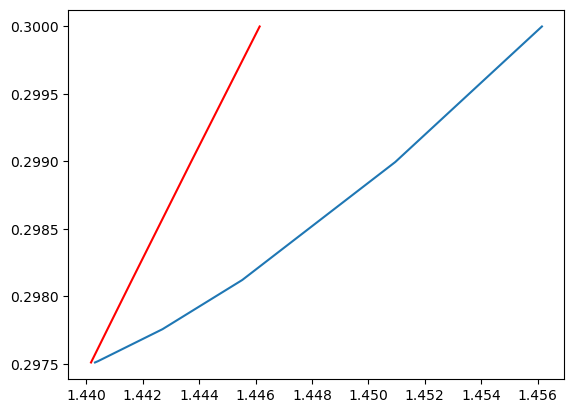

In [19]:

a = 0.99889
e0 = 0.3

minp = tr.func.min_p(e0, 1., a) + 1e-2

# traj = tr(1e6, 1e1, a, minp, e0, 1., dt = 1e-3, T=4.7e-5)
traj = tr(1e6, 1e1, a, minp, e0, 1., dt = 1e-3, T=4.75e-4)
print(traj[0])
minps = [tr.func.min_p(traj[2][k], 1., a) - 1e-5  for k in range(len(traj[0]))]
plt.plot(traj[1], traj[2])
plt.plot(minps, traj[2], 'r')

In [ ]:
a = 0.99889
e0 = 0.3
M = 1e6
mu = 1e1
minp = tr.func.min_p(e0, 1., a) + 1e-2

# traj = tr(1e6, 1e1, a, minp, e0, 1., dt = 1e-3, T=4.7e-5)
traj = tr(1e6, 1e1, a, minp, e0, 1., dt = 1e-3, T=4.75e-4)
print(traj[0])
minps = [tr.func.min_p(traj[2][k], 1., a) - 1e-5  for k in range(len(traj[0]))]
plt.plot(traj[1], traj[2])
plt.plot(minps, traj[2], 'r')

In [32]:
tr.func.min_p(e0, 1., a)

1.4461520395093892

In [50]:
tr.func.evaluate_rhs([1.445,e0,1.])

[-0.5367472184777032,
 -0.07735738100523581,
 0.0,
 0.4172738859855943,
 0.0837519393726852,
 0.019679508891182432]